# Climate Detectives: Analysing Samples

### Introduction
Today were going to be analysing the samples that we looked at yesterday. The Picarro machine is super advanced, but it does have some systemic errors that we have to correct ourselves. We first correct for the memory effect, which is when the machine remembers information from the previous sample which causes some bias when we first start analysing a new sample. We correct for memory by taking multiple measurements of the same sample and finding the difference between each measurement and the very last measurement that we make of that sample. 

The next type of bias that we have to correct for is the drift effect. Drift occurs as the machine is working for long periods of time. Gradually it will start saying that samples have a higher or lower value that it previously did. We correct by using a drift standard - in this case Vancouver - to figure out how much the instrument has drifted over time. Since we know that the isotopic ratio in our Vancouver didn't change, if the next Vancouver in the sequence has a higher isotopic ratio we can calculate the amount of dirft that occured between those two samples. 

The memory and drift effect exist for each isotpe that we analyse, therefore we find a memory function and drift function for each type.

In [35]:
# Import libraries
import numpy as np #array manipulation and math functions
import pandas as pd #dataframe manipulation
import scipy.interpolate as interp #import statistical functions for drift correction

import matplotlib.pyplot as plt #basic plotting functions for python
import seaborn as sns #fanicer plotting functions and colormaps

import cartopy.crs as ccrs #make plots with maps on them
import cartopy #add borders and rivers to our maps

### 1. Look at the Raw Data
The Picarro machine gives us a lot of data, to simplify the process for you, we're going to select the columns (or types of data) that we'll need for the correction. 

##### Columns to Keep
> - **Line**: Tracker over the entire sequence, we treat it kind of like a time variable
> - **Analysis**: A specific code for each vial in the sequence
> - **Inj Nr**: The nth injection of that sample (1-12), resets to 1 for each Analysis
> - **d(17_16)Mean**: The O17/O16 ratio for the sample
> - **d(18_16)Mean**: the O18/16 ratio for the sample
> - **d(D_H)Mean**: the H2/H1 ratio for the sample
> - **Sample**: The position in the sample tray

In [60]:
#start by reading in our raw data file
d = pd.read_csv("HKDS2231_IsoWater_20250727_001929.csv",skipinitialspace=True)

columns_to_keep = ["Line", "Analysis", "Inj Nr", "d(17_16)Mean", "d(18_16)Mean", "d(D_H)Mean", "Sample"]

d = d[columns_to_keep] #select only the columns that we said above
d = d.loc[1:]

#we can add labels to each sample to know which sample is which

#start by making a dictionary that maps the sample id to the position in the tray
label_positions = {83: "VAN", 94: "VAN", 105: "VAN", 115: "VAN", 84 :"CHIL", 85: "OSOY", 86: "CAST", 93: "CRES",
                    95: "CRAN", 96: "CROW", 103: "LETH", 104: "MED", 106: "CAL", 113: "SKE", 114: "VIC"}
d.loc[:,"Label"] = d["Sample"] #make a copy of the sample column to replace with the labels above
d.replace({"Label": label_positions}, inplace = True)

samples_num = {"VAN": 1, "CHIL": 2, "OSOY": 3, "CAST": 4, "CRES": 5, "CRAN": 6, "CROW": 7, "LETH": 8, "MED": 9, "CAL": 10, "VIC": 11, "SKE": 12} 
#here we're mapping the label of a sample to a number, this allows
#for us to keep track of which sample is which once we start working with the means (which can't be averaged since they are strings)

d["Label Num"] = d["Label"].replace(samples_num)
d

C:\Users\jrobs\AppData\Local\Temp\ipykernel_26308\1220464803.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d["Label Num"] = d["Label"].replace(samples_num)


,Line,Analysis,Inj Nr,d(17_16)Mean,d(18_16)Mean,d(D_H)Mean,Sample,Label,Label Num
1,393,P-993,1,-6.802,-12.790,-109.307,83,VAN,1
2,394,P-993,2,-6.701,-12.633,-107.935,83,VAN,1
3,395,P-993,3,-6.696,-12.602,-107.481,83,VAN,1
4,396,P-993,4,-6.751,-12.639,-107.443,83,VAN,1
5,397,P-993,5,-6.717,-12.586,-107.333,83,VAN,1
...,...,...,...,...,...,...,...,...,...
364,756,P-1022,8,-6.520,-12.249,-105.338,115,VAN,1
365,757,P-1022,9,-6.509,-12.198,-105.090,115,VAN,1
366,758,P-1022,10,-6.515,-12.231,-105.228,115,VAN,1
367,759,P-1022,11,-6.515,-12.234,-105.143,115,VAN,1


Now let's make a plot of the raw data. The scaffolding of code to plot one kind of data has been written but it's missing a couple of things. Use the functions below to write code that labels the x and y axis and to gives the plot an informative title, feel free to change the color and the marker of the scatterplot. Then copy and paste the code below the line indicated to plot the other 2 types of data.

`plt.xlabel("")`
`plt.ylabel("")`
`plt.title("")`

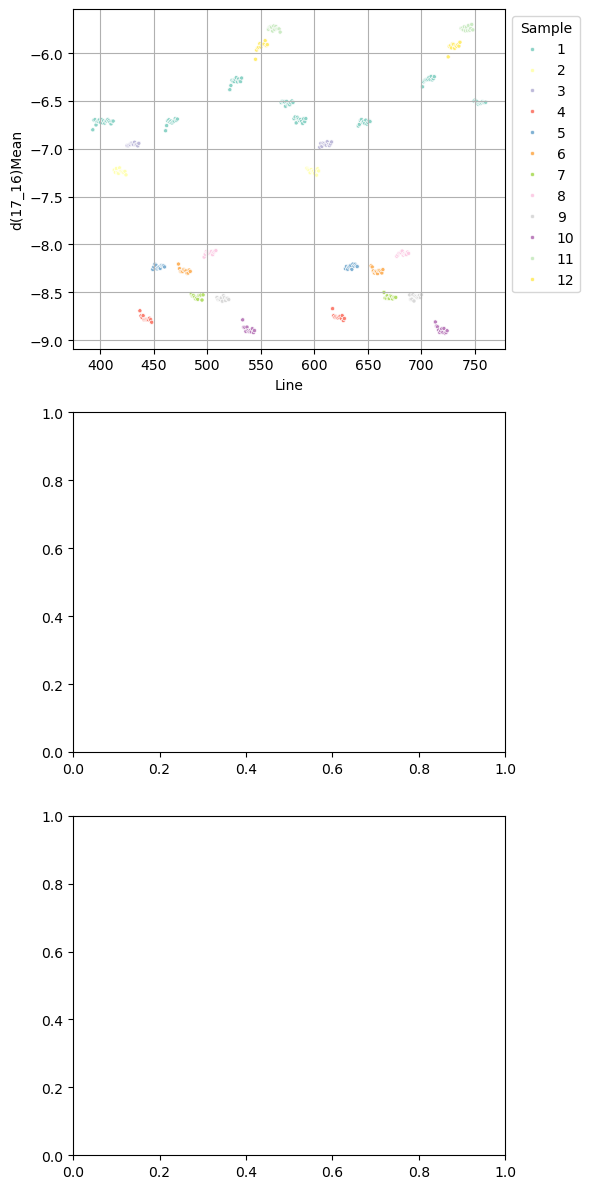

In [61]:
#let's make 3 plots of the raw data

d_sam = d #d[d["Label"] == "CRES"] we can change this if we want to look at a specific sample

f = plt.figure(1, figsize = (6,12))
plt.subplot(3,1,1)
######################### copy and paste from here
sns.scatterplot(data = d_sam, x = "Line", y = "d(17_16)Mean", marker = ".", hue = "Label Num", palette = "Set3")
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = "Sample")
#code for the labels goes under here

######################### to here
#code of d(18_16)Mean plot
plt.subplot(3,1,2)

#code for d(D_H)Mean plot
plt.subplot(3,1,3)


plt.tight_layout()

Can you see any of the memory / drift effect in these plots?

### 2. Memory Correction

Now let's correct for the memory effect. The code starts by calculating the fraction of the previous sample that remains in the current sample for each injection, we want to see that as the injection number increases (i.e as we make more measurements) we see that the fraction decreases. To do this we add 3 columns into the data with the `_f` ending. In general we don't want to overwrite any of the data that we gathered, instead we add and track the progress as we correct.

The fraction is calculated using the following equation where the numerator is the difference between the previous injection and the current injection and the denomenator is the difference between the previous injection and the last injection of the previous sample.

$$ d_{f,i}= \frac{d_{i-1} - d_i}{d_{i-1} - d_{prev}} $$

We add 3 columns into our dataframe with the ending `_memcor` which are the memory corrected data. The correction is applied using the equation below. We subtract the value of the last injection of the previous sample multiplied by the fraction of memory that we found for the current sample and injection, then we divide by 1 - the memory fraction. If there is no memory effect ($d_f = 0$) then no correction is applied.

$$ d_{memcor, i} = \frac{d_i - (d_f * d_{prev})}{1-d_f} $$

All of the code to do this correction is below, all you need to do is run the cell. The code is annotated so that you know what is happening but if you have questions don't hesitate to ask.

##### A. Run the code below to correct for the memory effect

In [62]:
#start by reading in the memory coefficients
fmemory = pd.read_csv("MemoryCoefficients_17O_20250214.csv")

cl = ["d(17_16)Mean", "d(18_16)Mean", "d(D_H)Mean"]

for c in cl: #loops let us iterate over objects in a list/array so that we can speed up the code writing process. Instead of writing the same 
    #code three times for each set of data, we're going to loop over a list of the names of the columns so that we can select each column

    #here we're making new columns to calculate the memory fraction
    cn=c+'_last'
    d[cn]=np.nan # create column
    cn=c+'_previous'
    d[cn]=np.nan  # create column
    cn=c+'_fmem' #for the memory %
    d[cn]=np.nan  # create column
    
    for a in d.Analysis.unique()[1:]: #we need to skip the first run since we don't have a previous sample to work with
        d.loc[d['Analysis']==a,c+'_last']=d.loc[d['Analysis']==a,c].to_numpy()[-3:-1].mean()
        ind = d.loc[d['Analysis']==a,'Line'].to_numpy()[0] - 1 #find the last value of previous analysis
        d.loc[d['Analysis']==a,c+'_previous'] = d.loc[d['Line']==ind,c].to_numpy()[0]

        # Calculate memory fraction:
        d[c+'_fmem'] = (d[c+'_last']-d[c].astype(float))/(d[c+'_last']-d[c+'_previous'])
    
    d[c+'_memcor']=d[c] # make a new column for the memory corrected data that we can work on
    d[c+'_f']=0.0 #make a column for the memory fraction

        #######
    for inj in d['Inj Nr']: #now we're also looping over the injection number, so for each c in cl, we're also looking at each inj in inj_Nr
    #this lets us do the calculation for each measurement that the machine made
            
        d.loc[d['Inj Nr']==inj,c+'_f'] = fmemory.loc[inj,c+'_fmem'] #we're putting the memory fraction associated with that injection
        #number into the right spot in the memory fraction column
        #######    

    d[c+'_memcor'] = (d[c]-d[c+'_f']*d[c+'_previous'])/(1-d[c+'_f'])
    #correct for the memory effect using the equation above
    

Now lets make a plot of our newly corrected data!

##### B. Copy and paste the code from the raw data plot into the cell below. Can you write code to add the memory corrected data to the plot in a different colour?

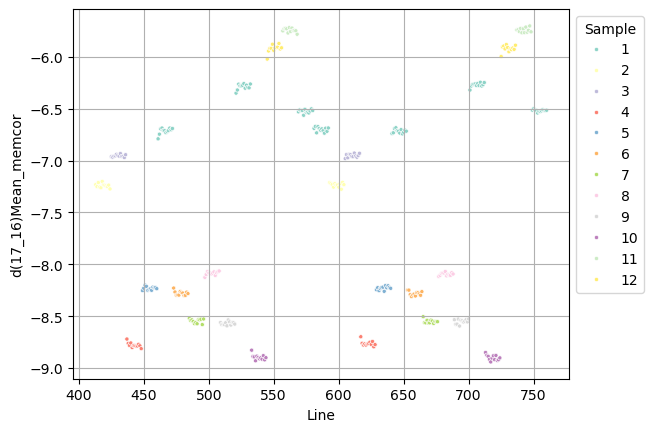

In [63]:
## Memory Corrected Data

#select the sample that we want to look at
d_sam = d #d[d["Label"] == 'CHIL']


plt.figure(2)
## add the plotting code below


Can you see anything weird about these plots? In order to ensure that the measurement is the most accurate that it could be, and to hopefully remove any remaining memory effect from the sample, we are only going to be using the 4th injection onward for our final dataset. Our final result is going to be the average of all of the data points for that sample and we can clearly see that the memory correction works best on later injections.

### 3. Drift Correction

Instruments drift for a variety of reasons. Small temperature variations or vibrations from the instrument runninng can cause it to think that the ratio is larger / smaller than it should be. The good news is that we can correct this instrument drift using a **drift standard**. A drift standard is a sample where we know what the correct isotopic ratio and can therefore calculate how different our measurements are from that standard. The sequence is designed so that it starts and ends with a drift standard, and we analyse a drift standard every 4 samples. 

We do the drift correction on the **anomalies** of the data. An anomaly is the difference between a given measurement and the average of all of the measurements in the set. We calculate the anomaly with respect to the Analysis of the sample. 

Then we apply what is called a **linear interpolation** between the standard anomalies. This means that we find a straight line between the average of each anomaly and subtract the points on the line from the data. 

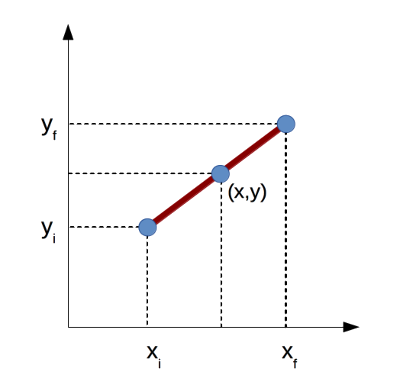

##### A. Add the drift standard label into the correct line of code to select only the samples from Vancouver `"VAN"`. Then, run the code below to correct for drift.

In [64]:
#drift correction code

d1=d.loc[d['Inj Nr']>3].copy() #we're making a new dataframe where we only take injection numbers greater than 3
samplelist = samplelist = d['Sample'].unique() #here we're making a list of each of the vials that were analysed in the tray

drift_standard_value = {"d(D_H)Mean": -107 ,"d(18_16)Mean": -12.38, "d(17_16)Mean": -6.57} #these are the true values of our drift standard

#calculate the anomalies for each type of data
dsam_mean=d1.groupby('Sample')[cl].mean() #for each sample, we're taking the mean for the anonalies
for c in cl: #loop over each type of data
    d1[c+'_anom']=0.0 #add a column into our dataframe
    for s in samplelist: #loop over each sample
        d1.loc[d1['Sample']==s,c+'_anom'] = d1.loc[d1['Sample']==s,c]-dsam_mean.loc[s,c] #subtract the mean of that sample group from the sample

d_means = d1.groupby("Analysis").mean(numeric_only = True) #find the mean of every column for each Analysis
#we use the means for the interpolation but we're going to correct all of the data using the interpolation

#select the the drift standard label data for the interpolation
d_stnd = d_means.loc[d_means["Label Num"] == samples_num["VAN"]].groupby("Analysis").mean(numeric_only = True)

for i,c in enumerate(cl):
    #get interpolation function
    d1_interpolation = interp.interp1d(d_stnd["Line"], d_stnd[c + "_anom"], 
                                                kind = "linear", bounds_error = False,
                                            fill_value = (d_stnd[c + "_anom"][0], d_stnd[c+ "_anom"][-1]))

    delta_mean = drift_standard_value[c] - d_stnd[c].mean() #delta mean is the difference between our measured drift standard and the true value
    #interpolate data
    d1[c + "_interp"] = d1_interpolation(d1["Line"])
    #correct data
    d1[c + "_driftcor"] = d1[c] - d1[c + "_interp"] #+ delta_mean #correct the data

C:\Users\jrobs\AppData\Local\Temp\ipykernel_26308\4054898401.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fill_value = (d_stnd[c + "_anom"][0], d_stnd[c+ "_anom"][-1]))
C:\Users\jrobs\AppData\Local\Temp\ipykernel_26308\4054898401.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fill_value = (d_stnd[c + "_anom"][0], d_stnd[c+ "_anom"][-1]))
C:\Users\jrobs\AppData\Local\Temp\ipykernel_26308\4054898401.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

##### B. Make the same plot as above, but show all 3 stages of the data (uncorrected, memory corrected, drift corrected). Make each stage of the processing a different color (you can use the website https://matplotlib.org/stable/gallery/color/named_colors.html) or hexcodes if you want to get creative. Here are some helpful keywords that you can add to the `plt.scatter()` function to make the plot more understandable.

>- `alpha`: reduces the opacity of the markers, alpha = 1 is full strength, alpha = 0 is invisble
>- `s`: changes the size of the marker, this one takes some fiddling since it changes the area occupied by the maker

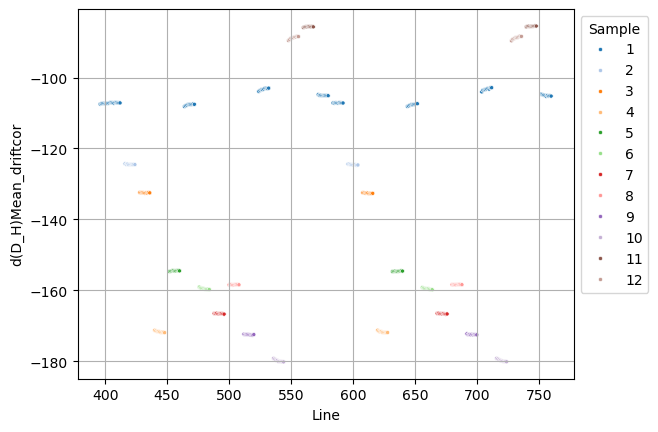

In [66]:
d_sam = d1 #d1[d1["Label"] == 'VAN']
##code for the plot here


### 4. Final Processing
We now have some pretty nice data that we can use to get an idea of the gradient accross Western Canada. Next we're going to find the delta excesses of the Deutrium and O17 data, which we find by taking the difference between the Deuterium fraction and the O18 fraction. 

$$ D \space excess = \delta ^2 H - 8 \cdot \delta ^{18}O $$
$$ ^{17} O \space excess = \delta ^{17} O - 0.52 \cdot \delta ^{18}O $$

##### A. Write code below to calculate the excesses of our data.

In [ ]:
#excess code here




Now that we have a clear picture about how to process data that comes from the Picarro analyser, we're ready to look at how the isotopic ratios are varying accross the region. Below is the code that we used to make the map of all of our sample sites, now we're going to color each dot by the mean isotopic ratio (or excess) for that sample. You should be able to see the gradient that occurs as heavier isotopes are shed on their way inwards.

In [71]:
# we're going to group by sample number, this essentially will take the mean for all of the datapoints in which the sample number is the same
#this is super useful when we want to see the results of our hard work

sample_locations = pd.read_csv("sample_locations.csv")

d_final = d1.groupby("Label").mean(numeric_only = True)
for i,l in enumerate(d_map.index): #for each of our samples we're going to find the correct coordinate pair to add to the dataframe
    lat = sample_locations[sample_locations["location_id"] == l]["lat"] #select the correct latitude coordinate 
    lon = sample_locations[sample_locations["location_id"] == l]["lon"] #select the correct longitude coordinate

    d_final.loc[i, "Lat"] = lat
    d_final.loc[i, "Lon"] = lon
d_map #you should see that there's now one line for each sample, with a whole bunch of information that we've calculated along the way.

In [ ]:
#here we're going to make the map
ax = plt.subplot(1,1,1, projection = ccrs.Orthographic(central_longitude= 240, central_latitude=39))
ax.set_extent([-125, -110, 45, 55])
ax.coastlines() #adds the coastline
ax.add_feature(cartopy.feature.BORDERS, linewidth=1.5, edgecolor = "0.5") #adds the border between Canada and the US
ax.add_feature(cartopy.feature.STATES, edgecolor = "0.2") #adds provincal and state borders
ax.add_feature(cartopy.feature.RIVERS, edgecolor = "lightblue") #adds the rivers

#add labels for the provinces and states
ax.annotate("BC", xy = (-125.5, 54.7), transform = ccrs.PlateCarree())
ax.annotate("AB", xy = (-119, 54.9), transform = ccrs.PlateCarree())
ax.annotate("WA", xy = (-124.3, 47.7), transform = ccrs.PlateCarree())
ax.annotate("MT", xy = (-115.5, 48.5), transform = ccrs.PlateCarree())
ax.annotate("ID", xy = (-116.8, 48.5), transform = ccrs.PlateCarree())

#add dots where each sample was collected
plt.scatter(sample_locations["Lon"], sample_locations["Lat"], transform = ccrs.PlateCarree(), cmap = "inferno", marker = ".")
#If you want to change the color of the dots, change what comes after the "color = " section in the above line of code
#changing what comes after the "marker = " will change what gets plotted as the "dot", If you want stars, change it to "*", triangles? "v"

#save the figure as a png file
plt.savefig("sample_map.png")


#### Congratulations! You've just completed the processing stage of our samples. Look over the plots that we made here, what else would you like to see? Use this notebook to play around with the code and the data and make some fun plots :) 